Broj slika: 6716, broj maski: 6716
Hematoxylin kanal - min: 0.0, max: 0.10004345782616782


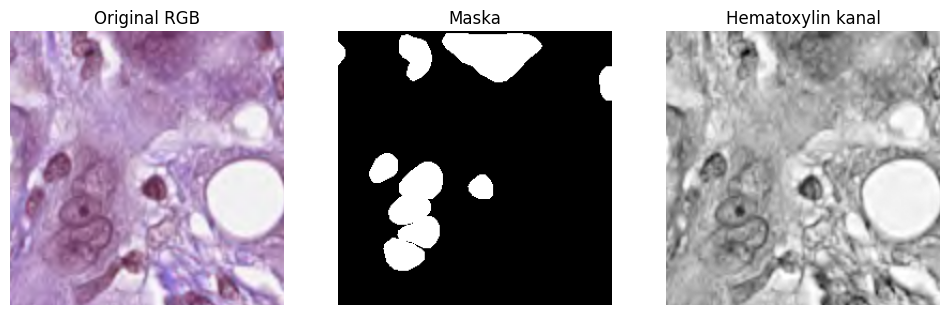

In [155]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

# Folderi
image_dir = r"C:\Users\User\Desktop\abs\projekat\dataset\images"
mask_dir = r"C:\Users\User\Desktop\abs\projekat\dataset\masks"

# Lista fajlova (sortiranje da se poklapaju imena slika i maski)
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

print(f"Broj slika: {len(image_files)}, broj maski: {len(mask_files)}")

# === Učitaj primer ===
idx = 1
img_path = os.path.join(image_dir, image_files[idx])
mask_path = os.path.join(mask_dir, mask_files[idx])

img = io.imread(img_path)   # RGB
mask = io.imread(mask_path) # maske su često grayscale ili RGB sa labelama


# === Stain deconvolution: Hematoxylin kanal ===
hed = color.separate_stains(img, color.hed_from_rgb)
hematoxylin_channel = hed[:, :, 0]   # prvi kanal = Hematoxylin
print(f"Hematoxylin kanal - min: {hematoxylin_channel.min()}, max: {hematoxylin_channel.max()}")


# Normalizacija na [0,1]
H_norm = (hematoxylin_channel - hematoxylin_channel.min()) / (hematoxylin_channel.max() - hematoxylin_channel.min())




# === Prikaz ===
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Maska")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(1-H_norm, cmap="gray")
plt.title("Hematoxylin kanal")
plt.axis("off")


plt.show()


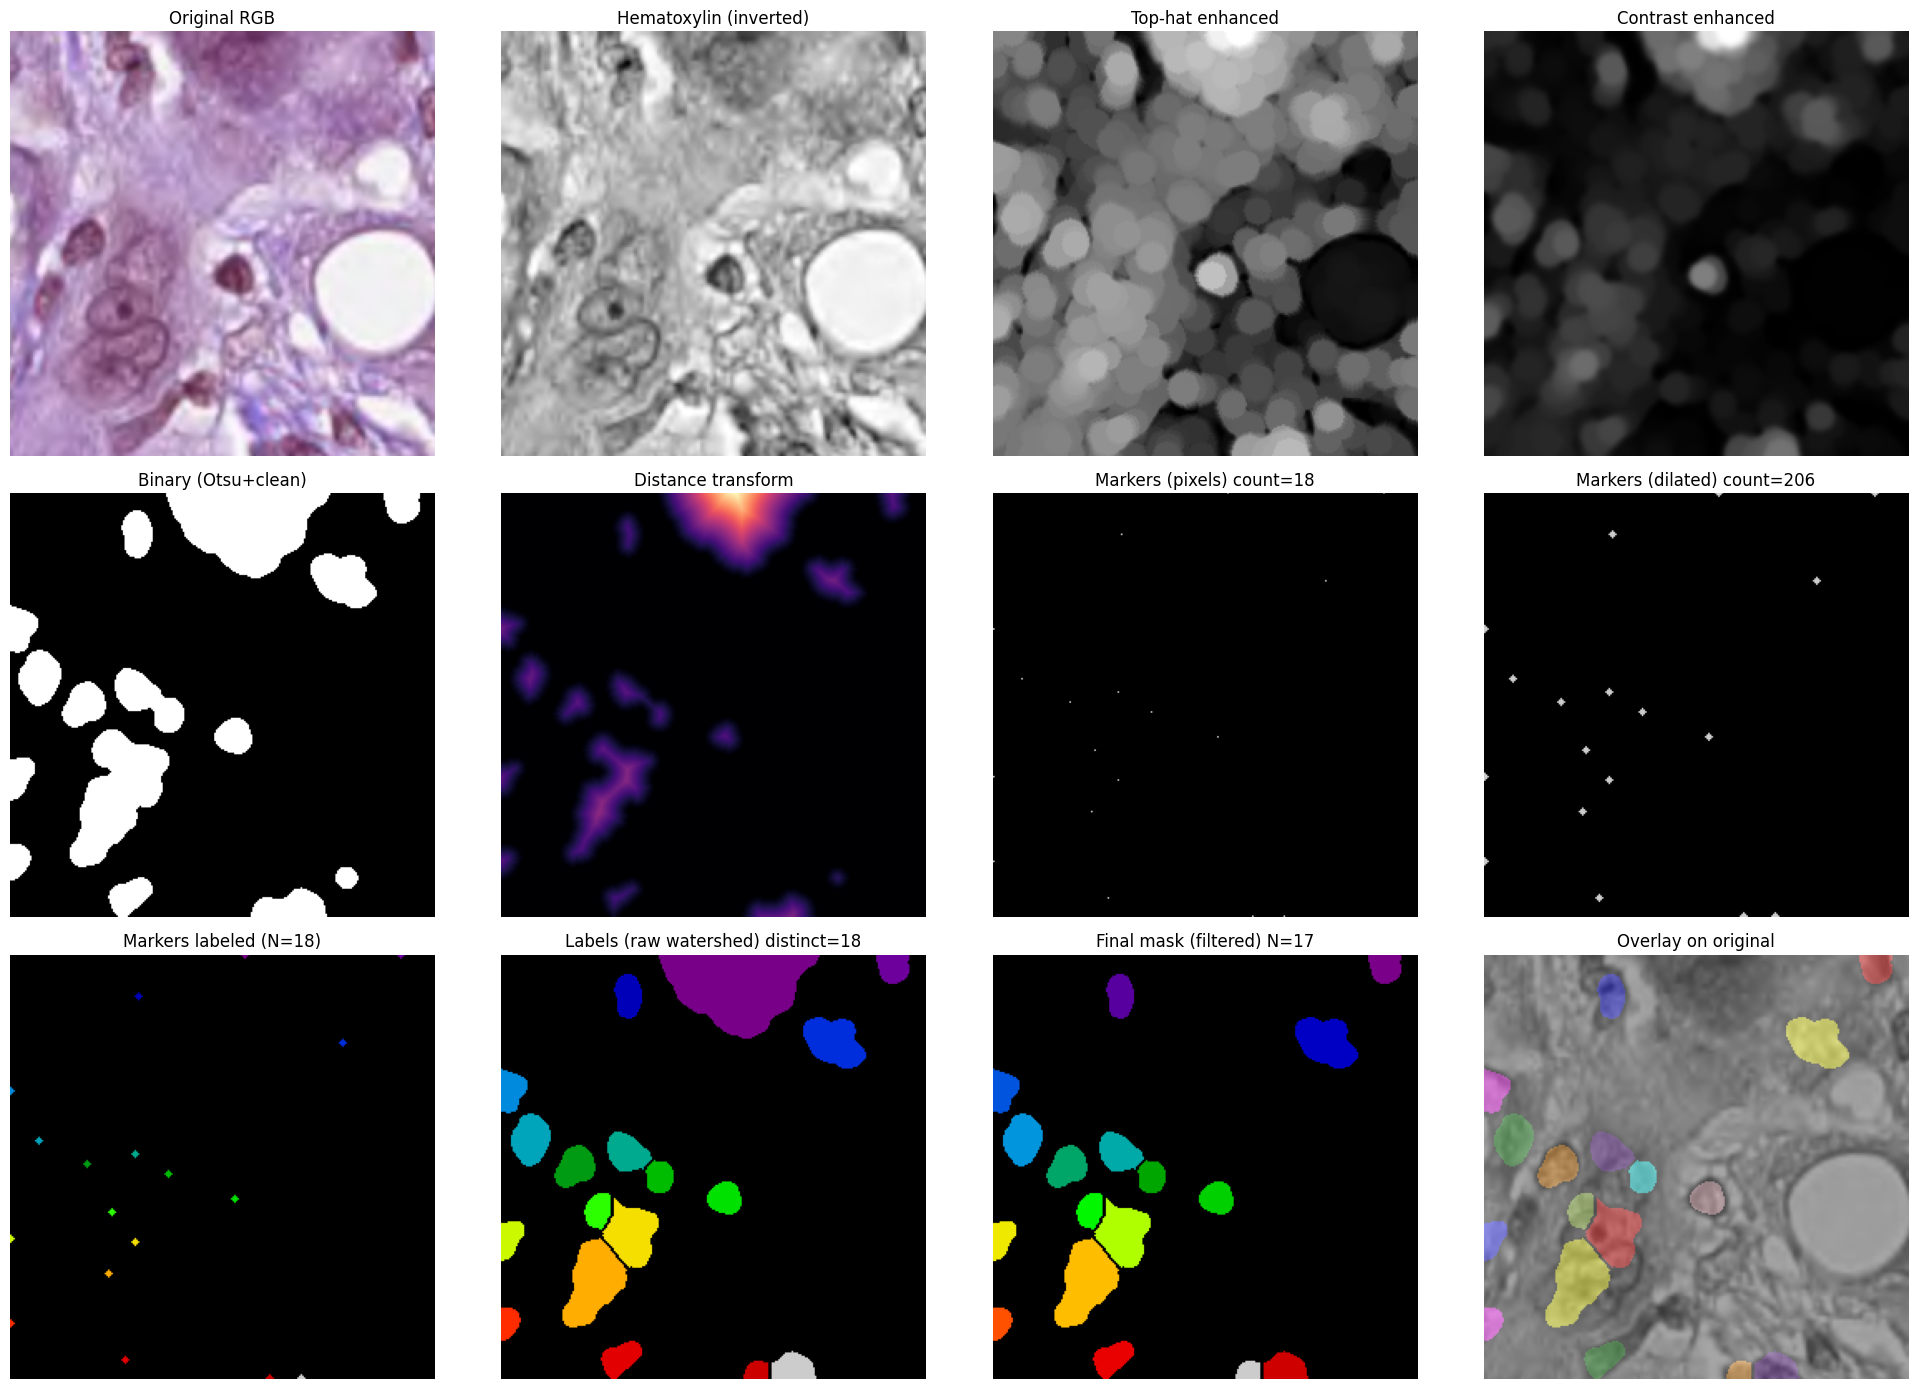

Markers (pixel count): 18
Markers (dilated pixel count): 206
Markers (labels): 18
Final detected instances: 17
Average area: 445.8235294117647
count      17.000000
mean      445.823529
std       291.983355
min       142.000000
25%       270.000000
50%       351.000000
75%       458.000000
max      1266.000000
Name: area, dtype: float64
{'adapted_rand_error': 0.5415789709952661, 'adapted_rand_precision': 0.558842270812336, 'adapted_rand_recall': 0.388592791703342, 'variation_of_information': 1.3098853890563777, 'pixel_accuracy': 0.85028076171875, 'precision': 0.11764705882352941, 'recall': 0.2857142857142857, 'f1_score': 0.16666666666666666, 'true_positives': 2, 'false_positives': 15, 'false_negatives': 5}


In [189]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, segmentation, exposure, measure
from scipy import ndimage as ndi
from scipy.ndimage import binary_fill_holes, distance_transform_edt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import disk, remove_small_objects, white_tophat, dilation
from skimage.color import label2rgb
import pandas as pd

# -------------------
# Pomoćne funkcije
# -------------------
def normalize01(x):
    rng = (x.max() - x.min())
    return (x - x.min()) / rng if rng != 0 else np.zeros_like(x)

from skimage.feature import peak_local_max

def compute_markers_from_distance(distance, min_distance=8, threshold_rel=0.2,
                                  dilate_radius=2, min_markers=5):
    """
    Generiše watershed markere iz distance mape.
    """
    # peak_local_max vraća BINARY MASK (True na maksimumima)
    local_max_mask = peak_local_max(distance,
                                    min_distance=min_distance,
                                    threshold_abs=distance.max() * threshold_rel,
                                    exclude_border=False)

    # osiguraj da je to bool maska iste veličine kao distance
    if local_max_mask.dtype != bool:
        # Ako vrati koordinate (u starijim verzijama) -> napravi masku
        coords = local_max_mask
        local_max_mask = np.zeros_like(distance, dtype=bool)
        local_max_mask[tuple(coords.T)] = True

    markers_pixels = local_max_mask.astype(np.uint8)

    # fallback ako nema dovoljno markera
    if markers_pixels.sum() < min_markers:
        morph_max = morphology.local_maxima(distance)
        markers_pixels = np.logical_or(markers_pixels, morph_max).astype(np.uint8)

    # dilatacija radi vizualizacije i stabilnijeg watershed-a
    if dilate_radius > 0:
        markers_dil = dilation(markers_pixels, disk(dilate_radius))
    else:
        markers_dil = markers_pixels

    # labeluj markere
    markers_labeled = ndi.label(markers_dil)[0]

    return markers_pixels, markers_dil, markers_labeled


# -------------------
# Glavna funkcija
# -------------------
def advanced_cell_segmentation(img,
                               min_cell_size=50,
                               max_cell_size=2000,
                               gaussian_sigma=1.5,
                               watershed_min_distance=8,
                               marker_threshold_rel=0.2,
                               marker_dilate_radius=2,
                               verbose=True):
    """
    Napredna segmentacija ćelija (H&E). Vraća:
      final_mask: labeled instance mask (0 = background)
      binary_mask: binarna maska (bool)
      cell_properties: pandas DataFrame sa regionprops
    """
    # 1) STAIN SEPARATION
    hed = color.separate_stains(img, color.hed_from_rgb)
    hematoxylin = hed[:, :, 0]

    # 2) NORMALIZACIJA I PREDPROCESING
    Hn = normalize01(hematoxylin)         # 0..1, svetlije = više H
    H_inv = 1 - Hn                        # invertovano (jedra tamna) za vizualizaciju

    # 3) TOP-HAT & ENHANCEMENT
    tophat = white_tophat(Hn, footprint=disk(8))
    enhanced = Hn - tophat
    smoothed = filters.gaussian(enhanced, sigma=gaussian_sigma)
    enhanced_contrast = exposure.adjust_sigmoid(smoothed, cutoff=0.5, gain=10)

    # 4) THRESHOLDING & MORPH CLEANING
    otsu = filters.threshold_otsu(enhanced_contrast)
    binary = enhanced_contrast > otsu
    binary = remove_small_objects(binary, min_size=min_cell_size)
    binary = binary_fill_holes(binary)
    binary = morphology.binary_opening(binary, footprint=disk(2))
    binary = morphology.binary_closing(binary, footprint=disk(2))

    # 5) DISTANCE & MARKERS
    dist = distance_transform_edt(binary)
    markers_pixels, markers_dil, markers_labeled = compute_markers_from_distance(
        dist,
        min_distance=watershed_min_distance,
        threshold_rel=marker_threshold_rel,
        dilate_radius=marker_dilate_radius,
        min_markers=5
    )

    # 6) WATERSHED
    labels = watershed(-dist, markers_labeled, mask=binary)
    w_lines = segmentation.find_boundaries(labels, mode='thick')
    labels[w_lines] = 0

    # 7) FILTER po veličini
    props = measure.regionprops(labels)
    valid_mask = np.zeros_like(labels, dtype=bool)
    for p in props:
        if min_cell_size <= p.area <= max_cell_size:
            valid_mask[labels == p.label] = True

    final_mask = measure.label(valid_mask)
    binary_final = final_mask > 0

    # 8) EXTRACT PROPERTIES
    final_props = measure.regionprops(final_mask, intensity_image=enhanced_contrast)
    rows = []
    for p in final_props:
        rows.append({
            'label': p.label,
            'area': p.area,
            'perimeter': p.perimeter,
            'centroid_x': p.centroid[1],
            'centroid_y': p.centroid[0],
            'eccentricity': p.eccentricity,
            'solidity': p.solidity,
            'extent': p.extent,
            'mean_intensity': p.mean_intensity,
            'equivalent_diameter': p.equivalent_diameter,
            'major_axis_length': p.major_axis_length,
            'minor_axis_length': p.minor_axis_length
        })
    cell_properties = pd.DataFrame(rows)

    # 9) VIZUALIZACIJA
    if verbose:
        fig, axes = plt.subplots(3, 4, figsize=(20, 14))
        axes = axes.ravel()

        axes[0].imshow(img); axes[0].set_title("Original RGB"); axes[0].axis('off')
        axes[1].imshow(H_inv, cmap='gray'); axes[1].set_title("Hematoxylin (inverted)"); axes[1].axis('off')
        axes[2].imshow(enhanced, cmap='gray'); axes[2].set_title("Top-hat enhanced"); axes[2].axis('off')
        axes[3].imshow(enhanced_contrast, cmap='gray'); axes[3].set_title("Contrast enhanced"); axes[3].axis('off')

        axes[4].imshow(binary, cmap='gray'); axes[4].set_title("Binary (Otsu+clean)"); axes[4].axis('off')
        axes[5].imshow(dist, cmap='magma'); axes[5].set_title("Distance transform"); axes[5].axis('off')

        axes[6].imshow(markers_pixels, cmap='nipy_spectral')
        axes[6].set_title(f"Markers (pixels) count={markers_pixels.sum()}"); axes[6].axis('off')

        axes[7].imshow(markers_dil, cmap='nipy_spectral')
        axes[7].set_title(f"Markers (dilated) count={markers_dil.sum()}"); axes[7].axis('off')

        axes[8].imshow(markers_labeled, cmap='nipy_spectral')
        axes[8].set_title(f"Markers labeled (N={markers_labeled.max()})"); axes[8].axis('off')

        axes[9].imshow(labels, cmap='nipy_spectral')
        axes[9].set_title(f"Labels (raw watershed) distinct={labels.max()}"); axes[9].axis('off')

        axes[10].imshow(final_mask, cmap='nipy_spectral')
        axes[10].set_title(f"Final mask (filtered) N={final_mask.max()}"); axes[10].axis('off')

        overlay = label2rgb(final_mask, image=img, bg_label=0, alpha=0.35)
        axes[11].imshow(overlay)
        axes[11].set_title("Overlay on original"); axes[11].axis('off')

        plt.tight_layout()
        plt.show()

        print("Markers (pixel count):", int(markers_pixels.sum()))
        print("Markers (dilated pixel count):", int(markers_dil.sum()))
        print("Markers (labels):", int(markers_labeled.max()))
        print("Final detected instances:", int(final_mask.max()))
        if not cell_properties.empty:
            print("Average area:", cell_properties['area'].mean())
            print(cell_properties['area'].describe())

    return final_mask, binary_final, cell_properties

# -------------------
# Evaluacija
# -------------------
def evaluate_segmentation(predicted_mask, ground_truth_mask, iou_threshold=0.5):
    """
    Evaluacija: predicted_mask može biti label maska ili binarna.
    ground_truth_mask: može biti RGB maska (non-zero = object) ili binarna.
    """
    from skimage.metrics import adapted_rand_error, variation_of_information

    # Predicted labels
    if predicted_mask.dtype == bool:
        pred_labels = measure.label(predicted_mask)
    else:
        pred_labels = measure.label(predicted_mask > 0)

    # Ground truth -> binarno i label
    if ground_truth_mask.ndim == 3:
        gt_binary = np.max(ground_truth_mask, axis=2) > 0
    else:
        gt_binary = ground_truth_mask > 0
    gt_labels = measure.label(gt_binary)

    # Adapted Rand Error (are, precision, recall)
    are, ar_precision, ar_recall = adapted_rand_error(gt_labels, pred_labels)

    # Variation of Information
    voi_split, voi_merge = variation_of_information(gt_labels, pred_labels)
    voi = voi_split + voi_merge

    # Pixel accuracy
    pixel_accuracy = np.sum((pred_labels > 0) == (gt_labels > 0)) / pred_labels.size

    # Instance IoU greedy matching
    pred_props = measure.regionprops(pred_labels)
    gt_props = measure.regionprops(gt_labels)
    tp = 0; fp = 0
    for p in pred_props:
        best_iou = 0
        for g in gt_props:
            inter = np.sum((pred_labels == p.label) & (gt_labels == g.label))
            union = p.area + g.area - inter
            iou = inter / union if union > 0 else 0
            if iou > best_iou:
                best_iou = iou
        if best_iou >= iou_threshold:
            tp += 1
        else:
            fp += 1
    fn = len(gt_props) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    metrics = {
        'adapted_rand_error': float(are),
        'adapted_rand_precision': float(ar_precision),
        'adapted_rand_recall': float(ar_recall),
        'variation_of_information': float(voi),
        'pixel_accuracy': float(pixel_accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'true_positives': int(tp),
        'false_positives': int(fp),
        'false_negatives': int(fn)
    }
    return metrics

# -------------------
# Primer upotrebe (izmeni putanje i idx prema potrebi)
# -------------------
image_dir = "C:/Users/User/Desktop/abs/projekat/dataset/images"
mask_dir = "C:/Users/User/Desktop/abs/projekat/dataset/masks"
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

idx = 1
img = io.imread(os.path.join(image_dir, image_files[idx]))
mask = io.imread(os.path.join(mask_dir, mask_files[idx]))
final_mask, binary_mask, props = advanced_cell_segmentation(img, verbose=True)
metrics = evaluate_segmentation(binary_mask, mask)
print(metrics)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

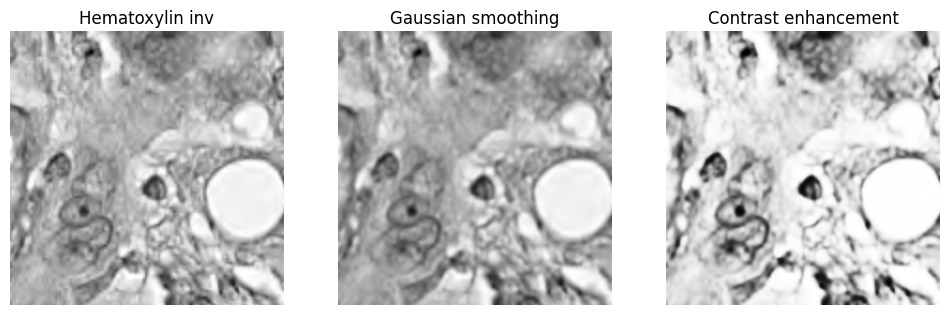

In [160]:
# Gaus - uklanjanje šuma
H_inv = 1 - H_norm

H_smooth = filters.gaussian(H_inv, sigma=1)

H_contrast = exposure.adjust_sigmoid(H_smooth, cutoff=0.5, gain=10)
# Prikaz
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(H_inv, cmap="gray")
plt.title("Hematoxylin inv")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(H_smooth, cmap="gray")
plt.title("Gaussian smoothing")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(H_contrast, cmap="gray")
plt.title("Contrast enhancement")
plt.axis("off")

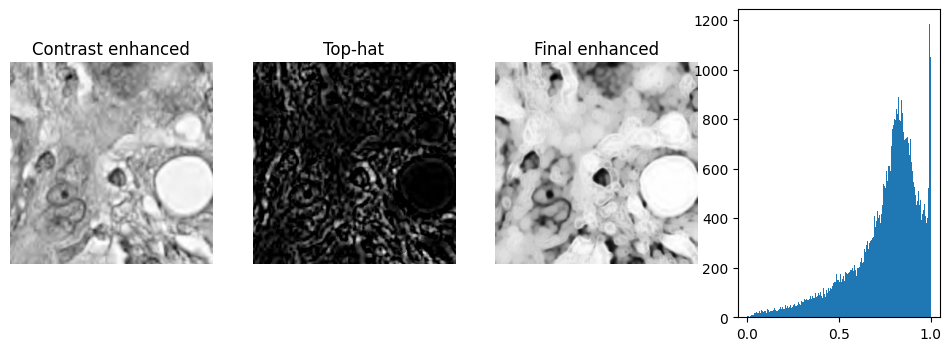

In [178]:
from skimage.morphology import white_tophat, disk
tophat = white_tophat(1-H_norm, footprint=disk(5))
m =  H_contrast - tophat

m_norm = (m - m.min()) / (m.max() - m.min())


plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(1-H_norm, cmap="gray")
plt.title("Contrast enhanced")
plt.axis("off")
plt.subplot(1,4,2)
plt.imshow(tophat, cmap="gray")
plt.title("Top-hat")
plt.axis("off")
plt.subplot(1,4,3)
plt.imshow(m_norm, cmap="gray")
plt.title("Final enhanced")
plt.axis("off")

plt.subplot(1,4,4)
plt.hist(m_norm.ravel(), bins=256)
plt.show()